# Define data to be used

In [38]:
import forex as fx
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp
import torch
from torchdiffeq import odeint
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp
from numba import njit
import scipy.optimize as opt
import numpy as np
import torch.nn as nn
import tqdm
import torch.nn.functional as F
from torchdiffeq import odeint
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D




_data = fx.min("EURUSD").data[0].to_numpy()
data = _data[:,2]


c:\Users\excal\OneDrive\Documents\GitHub\FinancialGamble\Forex\oanda\forex\utilities\_utils.py:54: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(pair, interval= "1m", period = "max",progress=False, ignore_tz=True).reset_index()


# Sim

In [2]:


@njit
def compute_accelerations(pos, masses, G, softening):
    n = len(masses)
    acc = np.zeros_like(pos)
    for i in range(n):
        for j in range(n):
            if i != j:
                dx = pos[j, 0] - pos[i, 0]
                dy = pos[j, 1] - pos[i, 1]
                dz = pos[j, 2] - pos[i, 2]
                r2 = dx*dx + dy*dy + dz*dz + softening*softening
                inv_r3 = 1.0 / (r2 * np.sqrt(r2))
                f = G * masses[j] * inv_r3
                acc[i, 0] += dx * f
                acc[i, 1] += dy * f
                acc[i, 2] += dz * f
    return acc

def sim(config, plot=False):
    G = config["G"]
    softening = config["softening"]
    initial_random_kick = config["initial_random_kick"]
    conserve_momentum = config["conserve_momentum"]
    make_barycenter_move = config["make_barycenter_move"]
    t_span = config["t_span"]
    t_eval = np.linspace(*t_span, config["dt"])

    bodies = config["bodies"]
    names = list(bodies.keys())
    n = len(names)
    masses = np.array([bodies[name]["mass"] for name in names])
    positions = np.array([bodies[name]["pos"] for name in names])

    # --- AUTO-CIRCULAR VELOCITY ---
    def compute_auto_velocities(positions, names, masses, G, jitter=0.02):
        n = len(names)
        vels = np.zeros_like(positions)
        central_idx = int(np.argmax(masses))
        M_central = masses[central_idx]
        pos_central = positions[central_idx]

        for i in range(n):
            if i == central_idx:
                continue
            r_vec = positions[i] - pos_central
            r = np.linalg.norm(r_vec) + 1e-12
            v_circ = np.sqrt(G * M_central / r)
            tangential = np.array([-r_vec[1], r_vec[0], 0.0])
            tangential /= np.linalg.norm(tangential)
            factor = 1.0 + jitter * (2.0 * (np.random.rand() - 0.5))
            vels[i] = tangential * v_circ * factor

        if initial_random_kick > 0.0:
            vels += initial_random_kick * np.random.randn(*vels.shape)
        return vels, central_idx

    velocities, central_idx = compute_auto_velocities(positions, names, masses, G, jitter=0.06)

    # --- APPLY CUSTOM VELOCITIES FROM CONFIG ---
    for i, name in enumerate(names):
        b = bodies[name]
        if "vel" in b:
            vel_vec = np.array(b["vel"], dtype=float)
            norm = np.linalg.norm(vel_vec)
            if norm < 1e-6:
                velocities[i] = np.zeros(3)
            elif norm < 2.0:  # treat as direction
                r_vec = positions[i] - positions[central_idx]
                r = np.linalg.norm(r_vec) + 1e-12
                v_circ = np.sqrt(G * masses[central_idx] / r)
                velocities[i] = (vel_vec / norm) * v_circ
            else:
                velocities[i] = vel_vec

    # --- MOMENTUM CONSERVATION ---
    total_momentum = (masses[:, None] * velocities).sum(axis=0)
    if conserve_momentum and not make_barycenter_move:
        velocities -= total_momentum / masses.sum()

    # --- Numba-Accelerated ODE Function ---
    def n_body_odes(t, y):
        pos = y[:3*n].reshape((n, 3))
        vel = y[3*n:].reshape((n, 3))
        acc = compute_accelerations(pos, masses, G, softening)
        return np.concatenate([vel.ravel(), acc.ravel()])

    # --- SOLVE ---
    y0 = np.concatenate([positions.ravel(), velocities.ravel()])


    sol = solve_ivp(
        n_body_odes, t_span, y0, t_eval=t_eval,
        rtol=1e-8, atol=1e-8, method='DOP853'
    )

    pos_sol = sol.y[:3*n].reshape((n, 3, -1))
    centroid_pos = pos_sol[0]
    distances_from_first = np.linalg.norm(pos_sol - centroid_pos[None, :, :], axis=1)

    # --- PLOT ---
    if plot:
        plt.figure(figsize=(9, 9))
        for i, name in enumerate(names):
            plt.plot(pos_sol[i, 0, :], pos_sol[i, 1, :], label=name, linewidth=0.9)
            plt.scatter(pos_sol[i, 0, 0], pos_sol[i, 1, 0], s=40)
        plt.title("N-body Trajectories")
        plt.xlabel("x"); plt.ylabel("y")
        plt.axis('equal'); plt.grid(True)
        plt.legend()
        plt.show()

        plt.figure(figsize=(10, 4))
        for i, name in enumerate(names):
            plt.plot(sol.t, distances_from_first[i], label=f"{name} | dist from first")
        plt.xlabel("time"); plt.ylabel("Distance from first planet")
        plt.grid(True)
        plt.legend()
        plt.show()

    return pos_sol, distances_from_first, names


# Optimizer Minimizer

In [3]:


def objective_function(x):
    assert len(x) 
    config = {
        "G": 1.0,
        "softening": 0.05,
        "initial_random_kick": 0.0,
        "conserve_momentum": True,
        "make_barycenter_move": True,
        "t_span": (0, 40),
        "dt": 14,
        "bodies": {
            "B": {"mass": 100.0, "pos": np.array([0.0, 0.0, 0.0])},
            "A": {"mass": x[0], "pos": np.array([x[2], x[3], x[4]]), "vel": np.array([x[5], x[6], x[7]])},
            "C": {"mass": x[1], "pos": np.array([x[8], x[9], x[10]]), "vel": np.array([x[11], x[12], x[13]])},
            "D": {"mass": x[1], "pos": np.array([x[8], x[9], x[10]]), "vel": np.array([x[11], x[12], x[13]])},
        }
    }
    positions, distances, names = sim(config, plot=False)
    mse_loss_fn = nn.MSELoss()
    # Reduce to scalar error (sum of squared differences)
    # return distances, mse_loss_fn(torch.tensor(distances[1,:]), data[:config["dt"]])
    return mse_loss_fn(torch.tensor(distances[1,:]), torch.tensor(data[:config["dt"]])).numpy()
    # return 1

initial_guess = np.random.randn(14)
initial_guess[0] = 1
initial_guess[1] = 1

# result = opt.minimize(objective_function, initial_guess, method='BFGS', options={"maxiter": 10, "disp" : True})

# print("Optimization Result:")
# print(f"Success: {result.success}")
# print(f"Message: {result.message}")
# print(f"Optimal x values: {result.x}")
# print(f"Minimum function value: {result.fun}")


# Redefine Sim to accept torch arrays

In [35]:
import torch
from torchdiffeq import odeint

def sim_torch(x, t_span=(0,28), dt=28, G=1.0, softening=0.05):
    """
    Differentiable N-body simulator in 3D.
    
    x: 1D tensor of shape (n_bodies * 7,)
       Format per body: [mass, pos_x, pos_y, pos_z, vel_x, vel_y, vel_z, ...]
    t_span: tuple (start_time, end_time)
    dt: number of time steps
    G: gravitational constant
    softening: softening to avoid singularities

    Returns:
        pos_sol: (n_bodies, 3, dt)
        distances: (n_bodies, dt) relative to first body
        masses: (n_bodies,) tensor of masses
    """
    n_bodies = x.shape[0] // 7

    # Extract masses, positions, velocities
    masses = torch.abs(x[::7])  # every 7th element starting at 0
    pos_list = [x[7*i + 1 : 7*i + 4] for i in range(n_bodies)]
    vel_list = [x[7*i + 4 : 7*i + 7] for i in range(n_bodies)]

    pos0 = torch.stack(pos_list, dim=0)  # (n_bodies, 3)
    vel0 = torch.stack(vel_list, dim=0)  # (n_bodies, 3)

    # Flatten for ODE solver
    y0 = torch.cat([pos0.flatten(), vel0.flatten()])

    t_eval = torch.linspace(t_span[0], t_span[1], dt)

    def n_body_odes(t, y):
        pos = y[:3*n_bodies].reshape(n_bodies, 3)
        vel = y[3*n_bodies:].reshape(n_bodies, 3)

        # Compute Newtonian accelerations
        acc = torch.zeros_like(pos)
        for i in range(n_bodies):
            for j in range(n_bodies):
                if i != j:
                    r_vec = pos[j] - pos[i]
                    r = torch.norm(r_vec) + softening
                    acc[i] += G * masses[j] * r_vec / r**3

        dydt = torch.cat([vel.flatten(), acc.flatten()])
        return dydt

    sol = odeint(n_body_odes, y0, t_eval)  # (dt, 6*n_bodies)

    # Reshape positions and velocities
    pos_sol = sol[:, :3*n_bodies].reshape(dt, n_bodies, 3).permute(1, 2, 0)  # (n_bodies, 3, dt)
    centroid_pos = pos_sol[0]  # reference body
    distances = torch.norm(pos_sol - centroid_pos[None, :, :], dim=1)  # (n_bodies, dt)

    return pos_sol, distances, masses


# Physics Informend Neural Netowrk

In [ ]:
softening = 0.05
G = 1.0

# -------------------------------
# PINN Acceleration
# -------------------------------


class PINN_Acceleration(nn.Module):
    def __init__(self, n_bodies, G=1.0, softening=0.05):
        super().__init__()
        self.n_bodies = n_bodies
        self.G = G
        self.softening = softening

        # Neural network to learn corrections to physics
        self.net = nn.Sequential(
            nn.Linear(n_bodies * 3, 64),
            nn.Tanh(),
            nn.Linear(64, n_bodies * 3)
        )

    def forward(self, pos, masses):
        """
        pos: (n_bodies, 3)
        masses: (n_bodies,)
        returns: (n_bodies, 3) accelerations
        """
        a_phys = torch.zeros_like(pos)

        # Newtonian gravity
        for i in range(self.n_bodies):
            for j in range(self.n_bodies):
                if i != j:
                    r_vec = pos[j] - pos[i]             # vector from i to j
                    r = torch.norm(r_vec) + self.softening  # distance with softening
                    a_phys[i] += self.G * masses[j] * r_vec / r**3

        # Neural network correction
        a_nn = self.net(pos.flatten()).reshape(self.n_bodies, 3)

        # Total acceleration
        return a_phys + a_nn

 20%|██        | 1/5 [00:03<00:12,  3.02s/it]

Epoch 0, Loss: 2679.403564


100%|██████████| 5/5 [00:10<00:00,  2.09s/it]


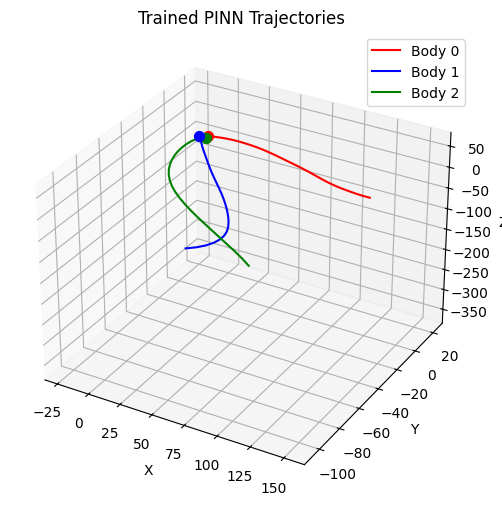

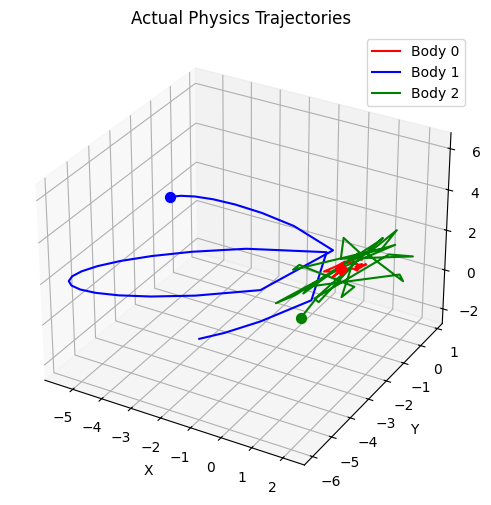

In [ ]:


# -------------------------------
# ODE function for PINN
# -------------------------------
def pinn_nbody_odes(t, y, nn_model, n_bodies, masses):
    pos = y[:3*n_bodies].reshape(n_bodies, 3)
    vel = y[3*n_bodies:].reshape(n_bodies, 3)
    acc = nn_model(pos, masses)
    dydt = torch.cat([vel.flatten(), acc.flatten()])
    return dydt

# -------------------------------
# nn_odeint wrapper
# -------------------------------
def nn_odeint(x, nn_model, t_span=(0,28), dt=28):
    n_bodies = x.shape[0] // 7
    masses = torch.abs(x[::7])

    pos_list = [x[7*i+1:7*i+4] for i in range(n_bodies)]
    pos0 = torch.stack(pos_list, dim=0)
    vel_list = [x[7*i+4:7*i+7] for i in range(n_bodies)]
    vel0 = torch.stack(vel_list, dim=0)

    y0 = torch.cat([pos0.flatten(), vel0.flatten()])
    t_eval = torch.linspace(t_span[0], t_span[1], dt)

    sol = odeint(lambda t, y: pinn_nbody_odes(t, y, nn_model, n_bodies, masses),
                 y0, t_eval, method='dopri5')

    pos_sol = sol[:, :3*n_bodies].reshape(dt, n_bodies, 3).permute(1,2,0)
    vel_sol = sol[:, 3*n_bodies:].reshape(dt, n_bodies, 3).permute(1,2,0)
    distances = torch.norm(pos_sol - pos_sol[:, :, 0:1], dim=1)
    accelerations = nn_model(pos_sol[:, :, -1], masses)
    return pos_sol, vel_sol, distances, accelerations

# -------------------------------
# 3-body system: Center + 2 moving bodies
# -------------------------------
dt = 28
t_span = (0, dt)
n_bodies = 3  # Center + 2 moving

# Initial guess x: [mass, pos_x, pos_y, pos_z, vel_x, vel_y, vel_z] * n_bodies
x = torch.zeros(n_bodies*7, dtype=torch.float32)

# Center body: fixed at origin, mass = 10
x[0] = 10.0  # mass
x[1:4] = 0.0  # pos
x[4:7] = 0.0  # vel

# Moving bodies: random initial guess
for i in range(1, 3):
    idx = i*7
    x[idx] = 1.0  # mass = 1
    x[idx+1:idx+4] = torch.randn(3) * 5.0  # random pos
    x[idx+4:idx+7] = torch.randn(3) * 0.1  # small random vel

# Reference distances (fake for demo, replace with actual if available)
reference_distances = torch.rand(n_bodies, dt)

x.requires_grad_()

# -------------------------------
# Train PINN
# -------------------------------
nn_model = PINN_Acceleration(n_bodies)
optimizer = torch.optim.Adam(list(nn_model.parameters()) + [x], lr=1e-2)
loss_fn = nn.MSELoss()
epochs = 5

for epoch in tqdm.tqdm(range(epochs)):
    optimizer.zero_grad()
    pos_sol, vel_sol, distances, accelerations = nn_odeint(x, nn_model, t_span, dt)
    loss = loss_fn(distances, reference_distances)
    loss.backward()
    optimizer.step()

    if epoch % 10 == 0:
        print(f"Epoch {epoch}, Loss: {loss.item():.6f}")

# -------------------------------
# Plot PINN
# -------------------------------
def plot_trajectories(pos_sol, title="Trajectories"):
    n_bodies = pos_sol.shape[0]
    dt = pos_sol.shape[2]
    colors = ['r','b','g','c','m','y']
    fig = plt.figure(figsize=(8,6))
    ax = fig.add_subplot(111, projection='3d')
    for i in range(n_bodies):
        ax.plot(pos_sol[i,0,:].detach().numpy(),
                pos_sol[i,1,:].detach().numpy(),
                pos_sol[i,2,:].detach().numpy(),
                color=colors[i%6], label=f'Body {i}')
        ax.scatter(pos_sol[i,0,0].detach().numpy(),
                   pos_sol[i,1,0].detach().numpy(),
                   pos_sol[i,2,0].detach().numpy(),
                   color=colors[i%6], marker='o', s=50)
    ax.set_xlabel('X'); ax.set_ylabel('Y'); ax.set_zlabel('Z')
    ax.set_title(title)
    ax.legend()
    plt.show()

plot_trajectories(pos_sol, title="Trained PINN Trajectories")

# -------------------------------
# Plot actual physics solution
# -------------------------------
def nbody_odes_physics(t, y, n_bodies, masses):
    pos = y[:3*n_bodies].reshape(n_bodies, 3)
    vel = y[3*n_bodies:].reshape(n_bodies, 3)
    acc = torch.zeros_like(pos)
    for i in range(n_bodies):
        for j in range(n_bodies):
            if i != j:
                r_vec = pos[j] - pos[i]
                r2 = (r_vec**2).sum() + softening**2
                acc[i] += G * masses[j] * r_vec / (r2 * torch.sqrt(r2))
    dydt = torch.cat([vel.flatten(), acc.flatten()])
    return dydt

def odeint_physics(x, t_span=(0,28), dt=28):
    n_bodies = x.shape[0] // 7
    masses = torch.abs(x[::7])
    pos0 = torch.stack([x[7*i+1:7*i+4] for i in range(n_bodies)], dim=0)
    vel0 = torch.stack([x[7*i+4:7*i+7] for i in range(n_bodies)], dim=0)
    y0 = torch.cat([pos0.flatten(), vel0.flatten()])
    t_eval = torch.linspace(t_span[0], t_span[1], dt)

    sol = odeint(lambda t,y: nbody_odes_physics(t,y,n_bodies,masses),
                 y0, t_eval, method='dopri5')

    pos_sol = sol[:, :3*n_bodies].reshape(dt,n_bodies,3).permute(1,2,0)
    vel_sol = sol[:, 3*n_bodies:].reshape(dt,n_bodies,3).permute(1,2,0)
    return pos_sol, vel_sol



pos_actual, distances, masses = sim_torch(x.detach(), t_span, dt)
plot_trajectories(pos_actual, title="Actual Physics Trajectories")


In [25]:
pos_sol.shape

torch.Size([2, 3, 28])

# Machine Learning 

In [5]:
# Example: 2 bodies (A,B) + Center
n_bodies = 3
n_per_body = 7
dt = 28
t_span = (0, 28)

# Initial guess: random parameters
x = torch.randn(n_bodies * n_per_body, dtype=torch.float32, requires_grad=True)

# Reference distances (e.g., from “true” simulation)
# For demo, let's pretend data[:dt] is reference distances for body 1
reference_distances = torch.rand(dt)  # replace with your real target distances

# Optimizer
optimizer = torch.optim.Adam([x], lr=1e-2)
loss_fn = F.mse_loss

epochs = 100
for epoch in range(epochs):
    optimizer.zero_grad()

    # Build config from current parameters
    config = {
        "G": 1.0,
        "softening": 0.05,
        "t_span": t_span,
        "dt": dt,
        "bodies": {"Center": {"mass": torch.tensor(100.0), 
                              "pos": torch.zeros(3), 
                              "vel": torch.zeros(3)}}
    }

    body_names = ["A", "B"][:n_bodies]
    for i, name in enumerate(body_names):
        start = i*n_per_body
        mass = torch.abs(x[start])  # pick scalar
        pos  = torch.tanh(x[start+1:start+4])         # positions bounded
        vel  = 0.1*torch.tanh(x[start+4:start+7])     # small velocities
        config["bodies"][name] = {"mass": mass, "pos": pos, "vel": vel}

    # Run differentiable simulation
    _, distances, _ = sim_torch(config)

    # Loss: MSE on distances of body 1 vs reference
    loss = loss_fn(distances[1], reference_distances)

    # Backprop and step
    loss.backward()
    optimizer.step()

    print(f"Epoch {epoch+1}/{epochs} | Loss: {loss.item():.6f}")


Epoch 1/100 | Loss: 0.601737
Epoch 2/100 | Loss: 0.578936
Epoch 3/100 | Loss: 0.638091
Epoch 4/100 | Loss: 0.590036
Epoch 5/100 | Loss: 0.614824
Epoch 6/100 | Loss: 0.575209
Epoch 7/100 | Loss: 0.582152
Epoch 8/100 | Loss: 0.600397
Epoch 9/100 | Loss: 0.635112


KeyboardInterrupt: 